In [6]:
import os
import zipfile

!bash setup.sh

import sagemaker
from sagemaker_predictive_maintenance import config, preprocess, utils

role = config.role

Obtaining file:///home/ec2-user/SageMaker/sagemaker_predictive_maintenance
  Attempting uninstall: sagemaker-predictive-maintenance
    Found existing installation: sagemaker-predictive-maintenance 1.0
    Uninstalling sagemaker-predictive-maintenance-1.0:
      Successfully uninstalled sagemaker-predictive-maintenance-1.0
  Running setup.py develop for sagemaker-predictive-maintenance


## Data Preparation
Data gathering, storing, denoising, alignment, curating and querying is THE most complicated aspect of predictive maintenance. Fault reports can for example be buried in pdf scans, fault types being misdiagnosed, fault only discovered weeks after they actually occured, or reported in a different timezone without the timezone information. These are a few of a thousands of pitfalls that may
await you when trying to collate such real-world dataset at scale. In this scenario we are using a hypothetical dataset where the data is cleaned and aligned.


### Background
NASA’s Prognostic Center of Excellence established a repository with datasets to be used for benchmarking prognostics and predictive maintenance related algorithms. Among these datasets involves data from a turbofan engine simulation model C-MAPPS (or Commercial Modular Aero Propulsion System Simulation). The references section contains details about the over 100 publications using this dataset. C-MAPPS is a tool used to generate health, control and engine parameters from a simulated turbofan engine. A custom code wrapper was used to inject synthetic faults and continuous degradation trends into a time series of sensor data. Some high level characteristics of this dataset are as follows:
The data obtained is from a high fidelity simulation of a turbofan engine, but closely models the sensor values of an actual engine. Synthetic noise was added to the dataset to replicate real-world scenarios. The effects of faults are masked due to operational conditions, which is a common trait of most real world systems.

In [66]:
source_data_location = 's3://sagemaker-solutions-us-west-2/Predictive-maintenance-using-machine-learning/data'

#local data folder
data_folder = 'data'

!aws s3 cp --recursive $source_data_location $data_folder


with zipfile.ZipFile(os.path.join(data_folder, 'CMAPSSData.zip'), "r") as zip_ref:
    zip_ref.extractall(data_folder)

download: s3://sagemaker-solutions-us-west-2/Predictive-maintenance-using-machine-learning/data/CMAPSSData.zip to data/CMAPSSData.zip


### Process  Data

There are 4 different training dataset, corresponding to 4 different engines, and we will train our models on each individually. But first we must preprocess the dataset. Since the example dataset we're using is small we can run the preprocessing code located in `preprocess.py` on this notebook instance. The preprocessing script computes the RUL (Remaining Useful Life) column for each engine data in the training dataset. We also apply min-max scaling to normalize our sensor readings to between 0 and 1 for each column. We read and preprocess the test data as well. It consists of sensor readings and the actual RUL. See the code in `preprocess.py` for more. To adapt this to your own dataset, you would need to implement your custom preprocessing for your dataset. We plot a few columns from the training data for visualization purposes.

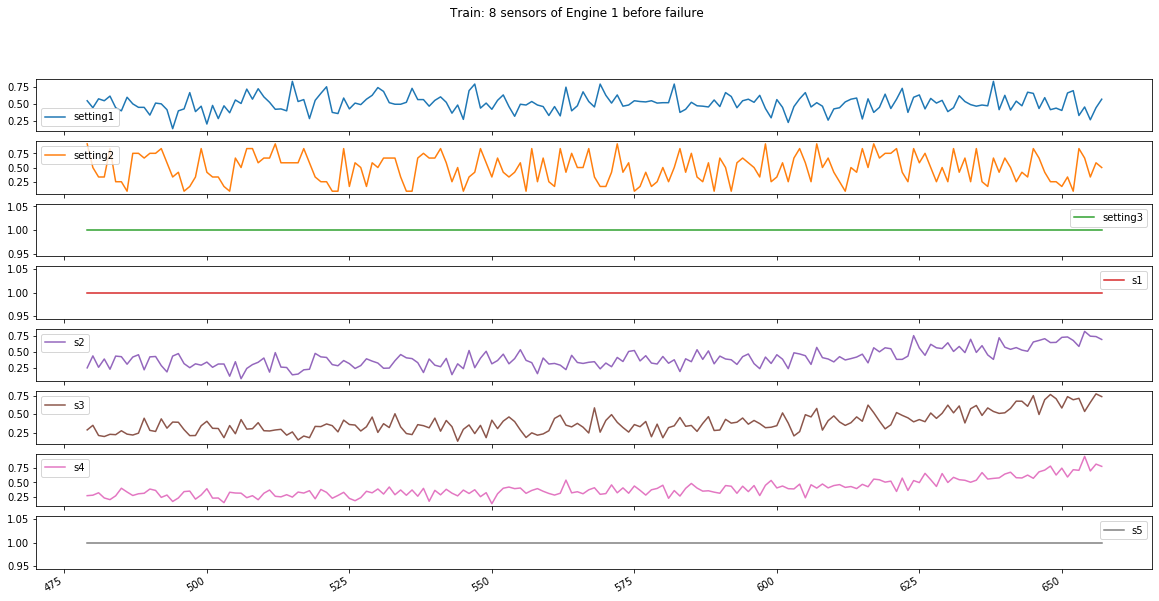

In [67]:
train_df, test_df, columns = preprocess.preprocess_data(data_folder)

o = train_df[0][columns[2:10]][train_df[0]['id'] == 3].plot(subplots=True, sharex=True, figsize=(20,10), title="Train: 8 sensors of Engine 1 before failure")

In [68]:
test_df[0].head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,0.656271,0.692544,1.0,1.0,0.596215,0.421968,0.282214,1.0,...,0.325583,0.152259,0.347079,1.0,0.375,1.0,1.0,0.500000,0.620100,142
1,1,2,0.343791,0.231360,1.0,1.0,0.182966,0.504025,0.225240,1.0,...,0.395350,0.277907,0.227712,1.0,0.500,1.0,1.0,0.645455,0.645719,141
2,1,3,0.531279,0.538816,1.0,1.0,0.419559,0.464814,0.346130,1.0,...,0.325583,0.192892,0.533559,1.0,0.500,1.0,1.0,0.700000,0.681104,140
3,1,4,0.775014,0.461952,1.0,1.0,0.413249,0.391587,0.449867,1.0,...,0.372094,0.217896,0.282362,1.0,0.250,1.0,1.0,0.627273,0.620383,139
4,1,5,0.600025,0.461952,1.0,1.0,0.435331,0.471306,0.357974,1.0,...,0.325583,0.187891,0.337012,1.0,0.125,1.0,1.0,0.618182,0.676009,138


## SageMaker Tensorflow Estimator

Now we will go over the steps needed to define the MXNet model and train with SageMaker.

### Upload processed data to S3 for training

We have to upload the processed data to a location in S3 so that the SageMaker training instance can access the data from that location. We will also, at the same time, upload the test data to the S3 bucket so that we can use that as an input to the trained model for scheduled inference.

In [69]:
from sagemaker.s3 import S3Uploader

bucket = config.solution_bucket
prefix = config.s3_prefix

s3_data_prefix = "s3://{}/{}/{}".format(bucket, prefix, 'data')

# Make local folder for processed data
! mkdir -p processed-data

# Upload processed test data for inference
for i in range(len(test_df)):
    local_test_file = 'processed-data/test-{}.csv'.format(i)
    test_df[i].to_csv(local_test_file, index=False)
    S3Uploader.upload(local_test_file, s3_data_prefix)

# Upload processed data for training
for i in range(len(train_df)):
    local_train_file = 'processed-data/train-{}.csv'.format(i)
    train_df[i].to_csv(local_train_file, index=False)
    S3Uploader.upload(local_train_file, s3_data_prefix)


print('uploaded training data location: {}'.format(s3_data_prefix))

uploaded training data location: s3://sm-soln-pred-maint-stack-s3bucket-wjs7p4sgisek/pred-maintenance-artifacts/data


### Set model output location

In [76]:
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://sm-soln-pred-maint-stack-s3bucket-wjs7p4sgisek/pred-maintenance-artifacts/output


### Tensorflow Autoencoder Model Training script

Training MXNet models using MXNet Estimators is a two-step process. First, you prepare your training script, then second, you run this on SageMaker via an MXNet Estimator. The training script we have prepared for the model is located in the `sagemaker_predictive_maintenance_entry_point` folder. 

The training script contains functions to create the model for training and for inference. We also have functions to convert our dataframes into a Gluon Dataset so that it can be efficiently prefetched, transformed into numerical features used by the network and padded so that we can learn from multiple samples in batches.

For more information on how to setup a training script for SageMaker using the Tensorflow estimator see [example notebooks](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_script_mode_training_and_serving/tensorflow_script_mode_training_and_serving.ipynb) or docs: https://sagemaker.readthedocs.io/en/stable/frameworks/tensorflow/using_tf.html

In [77]:
!cat sagemaker_predictive_maintenance/autoencoder_entry_point/requirements.txt

pandas==0.22
scikit-learn==0.23.1
scipy==1.4.1

In [78]:
!pygmentize sagemaker_predictive_maintenance/autoencoder_entry_point/autoencoder_entry_point.py

import argparse
import pandas as pd
import numpy as np
import itertools
import logging
import random
import os

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *

def get_logger(name):
    logger = logging.getLogger(name)
    log_format = '%(asctime)s %(levelname)s %(name)s: %(message)s'
    logging.basicConfig(format=log_format, level=logging.INFO)
    return logger


def parse_args():
    parser = argparse.ArgumentParser()

    parser.add_argument('--model_dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--training_dir', type=str, default=os.environ['SM_CHANNEL_TRAIN'])
    parser.add_argument('--num_dataset

### Train Tensorflow Estimator

Now, we can start the SageMaker training job by creating an MXNet estimator. We pass in the required arguments such as the `entry_point`, `role`, `train_instance_type`, and `train_instance_count` into the MXNet Estimator constructor.

Then we start the training script by calling `fit` on the MXNet Estimator. `fit` takes both required and optional arguments. The required argument here is the S3 location of the training data passed in as a dictionary. We are also adding an optional argument for the job name. This is important because when the training job is complete and SageMaker needs to create a SageMaker Model for real-time inference or batch transformation. 

In [ ]:
from sagemaker.tensorflow import TensorFlow

training_job_name = config.training_job_name
train_instance_type = 'ml.p3.2xlarge'

m = TensorFlow(entry_point='autoencoder_entry_point.py',
               source_dir='sagemaker_predictive_maintenance/autoencoder_entry_point',
               framework_version='2.0.0', # Tested on 
               py_version='py3',
               role=role, 
               train_instance_count=1, 
               train_instance_type=train_instance_type,
               output_path=output_location,
               hyperparameters={'num_datasets' : 1,
                                'batch_size': 512,
                                'epochs': 2, #25
                                'sequence_length': 50,
                                'validation_split': 0.2,
                                'patience': 6},
               input_mode='File',
               train_max_run=7200)

m.fit({'train': s3_data_prefix}) #, job_name=training_job_name)

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-09-28 09:14:33 Starting - Starting the training job...

### Create Transformer Model

We can now call the `transformer` function to create a SageMaker Model with the trained model. The SageMaker Model will have the same name as the training job that just completed. This will ensure that SageMaker stores a reference to the trained model which can be used for predictions later on. 

In [ ]:
batch_output = 's3://{}/{}/{}'.format(bucket, prefix, 'batch-inference')
transformer = m.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)

### Transform test data using the transformer model

Using the `transformer` SageMaker Model, we can run a [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) job to get some predictions on test dataset for the model. Here we have a function that takes some test data in S3 and copies it to a new location where it's used as the input to the `transform` function of the Batch Transformer.

In [ ]:
s3_test_key = "{}/data/test/test-0.csv".format(prefix)
s3_transform_input = "{}/batch-transform-input".format(prefix)

job_name, input_key = utils.get_transform_input(bucket, config.solution_prefix, s3_test_key, s3_transform_input)
transformer.transform(input_key, wait=True)

### View model prediction results

Once the transform job terminates, we can see the models predictions for the fractional remaining useful life left for the sensor readings in the `data/test-0.csv`. The predictions are a fraction of `MAX_RUL` which is `130.0`, therefore the Remaining Useful Life predictions can be obtained by multiplying the output with 130

In [11]:
utils.get_transform_output(bucket, prefix, job_name)

array([[[0.37493381],
        [0.37002832],
        [0.3721588 ],
        [0.37295875],
        [0.37176982],
        [0.36865494],
        [0.36591479],
        [0.36385596],
        [0.36100009],
        [0.35643724],
        [0.3512187 ],
        [0.34650189],
        [0.3421692 ],
        [0.33794174],
        [0.33425143],
        [0.33047763],
        [0.32596555],
        [0.32084098],
        [0.31539181],
        [0.31064004],
        [0.30597249],
        [0.30118114],
        [0.29571101],
        [0.29050094],
        [0.28482315],
        [0.27946419],
        [0.27397025],
        [0.26844195],
        [0.26141328],
        [0.24365959]]])

In [ ]:
# TODO: Compare with RUL predictions